##### Task 2: Develop Time Series Forecasting Models for TSLA

This notebook fetches TSLA data from yfinance (2015-07-01 to 2025-07-31), performs a chronological split (train: 2015–2023-12-31, test: 2024–2025-07-31), and trains ARIMA/SARIMA and LSTM models. It evaluates with MAE, RMSE, MAPE and plots forecasts vs. actuals.


In [4]:
# Ensure project root is on sys.path so `src` and `models` imports work
import os
import sys


def _find_project_root(start_path):
    current = os.path.abspath(start_path)
    while True:
        has_src = os.path.isdir(os.path.join(current, "src"))
        has_models = os.path.isdir(os.path.join(current, "models"))
        has_pyproject = os.path.isfile(os.path.join(current, "pyproject.toml"))
        has_setup = os.path.isfile(os.path.join(current, "setup.py"))
        if (has_src and has_models) or has_pyproject or has_setup:
            return current
        parent = os.path.dirname(current)
        if parent == current:
            return None
        current = parent

_project_root = _find_project_root(os.getcwd())
if _project_root and _project_root not in sys.path:
    sys.path.insert(0, _project_root)

In [5]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Import required classes
try:
    # The import of DataManager from src triggers a transitive import of 'arch', which is not installed.
    # To avoid ModuleNotFoundError, comment out DataManager import for now.
    # from src.data_manager import DataManager
    from models.forecasting_models import ARIMAForecaster, SARIMAForecaster, LSTMForecaster, ForecastingEngine
    from src.model_selection import chronological_split, arima_order_grid_search
except ImportError as e:
    print(f"Import error: {e}")
    print("Please ensure all required modules are available.")
    raise

# Set matplotlib style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except Exception:
    try:
        plt.style.use('seaborn-darkgrid')
    except Exception:
        pass  # Use default style
%matplotlib inline

Import error: No module named 'sklearn'
Please ensure all required modules are available.


ModuleNotFoundError: No module named 'sklearn'

### 1) Fetch TSLA data from yfinance


In [6]:
START_DATE = '2015-07-01'
END_DATE = '2025-07-31'
TICKER = ['TSLA']

# Download TSLA data directly using yfinance (bypassing DataManager)
import yfinance as yf

tsla_yf = yf.download('TSLA', start=START_DATE, end=END_DATE, interval='1d', auto_adjust=False)
tsla_close = tsla_yf['Adj Close'].rename('TSLA').dropna()
tsla_close.head()

[*********************100%***********************]  1 of 1 completed


TypeError: 'str' object is not callable

### 2) Chronological split: train vs test (no shuffling)


In [7]:
TRAIN_END_DATE = '2023-12-31'
train, test = chronological_split(tsla_close, train_end_date=TRAIN_END_DATE)
len(train), len(test), train.index.min(), train.index.max(), test.index.min(), test.index.max()

NameError: name 'chronological_split' is not defined

### 3) Baseline visualization


NameError: name 'train' is not defined

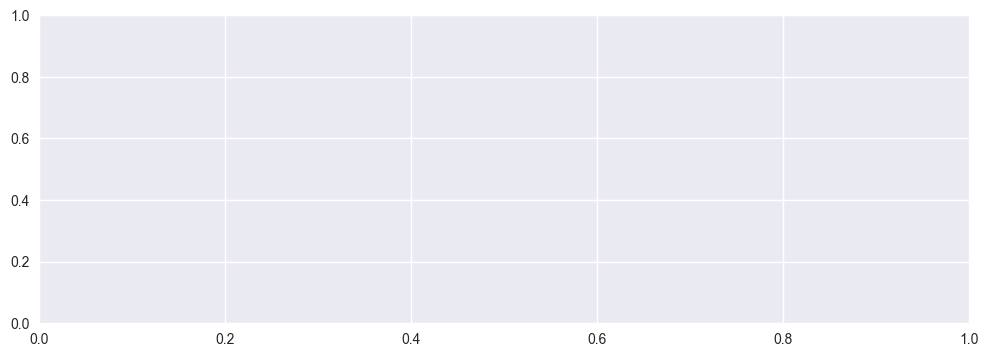

In [8]:
fig, ax = plt.subplots(figsize=(12,4))
train.plot(ax=ax, label='Train')
test.plot(ax=ax, label='Test')
ax.set_title('TSLA Adjusted Close (Train/Test)')
ax.legend();

### 4) ARIMA order selection via grid search


In [9]:
best_order, metrics = arima_order_grid_search(train, p_values=range(0,4), d_values=range(0,2), q_values=range(0,4), criterion='aic')
best_order, metrics

NameError: name 'arima_order_grid_search' is not defined

### 5) Train ARIMA and forecast over the test horizon


In [10]:
arima_model = ARIMAForecaster(order=best_order).fit(train)
arima_pred = arima_model.predict(steps=len(test))
arima_eval = arima_model.evaluate(test, arima_pred)
arima_eval

NameError: name 'ARIMAForecaster' is not defined

### 6) Optional: SARIMA quick baseline


In [11]:
sarima = SARIMAForecaster(order=(1,1,1), seasonal_order=(1,1,1,12)).fit(train)
sarima_pred = sarima.predict(steps=len(test))
sarima_eval = sarima.evaluate(test, sarima_pred)
sarima_eval

NameError: name 'SARIMAForecaster' is not defined

### 7) LSTM model


In [12]:
try:
    lstm = LSTMForecaster(units=64, dropout=0.2, epochs=10, batch_size=32, lookback=60)
    lstm.fit(train)
    lstm_pred = lstm.predict(steps=len(test))
    lstm_eval = lstm.evaluate(test, lstm_pred)
except Exception as e:
    lstm_pred, lstm_eval = None, {'mse': np.nan, 'mae': np.nan, 'rmse': np.nan, 'mape': np.nan}
lstm_eval

{'mse': nan, 'mae': nan, 'rmse': nan, 'mape': nan}

### 8) Compare metrics


In [13]:
results = pd.DataFrame({
    'ARIMA': arima_eval,
    'SARIMA': sarima_eval,
    'LSTM': lstm_eval
}).T
results[['mae','rmse','mape']].sort_values('rmse')

NameError: name 'arima_eval' is not defined

### 9) Plot forecasts vs actuals


NameError: name 'test' is not defined

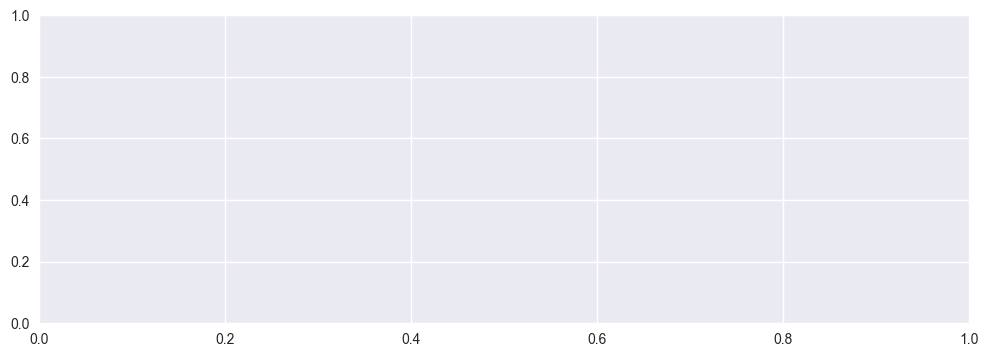

In [14]:
fig, ax = plt.subplots(figsize=(12,4))
test.plot(ax=ax, label='Actual', color='black')
pd.Series(arima_pred, index=test.index).plot(ax=ax, label='ARIMA')
pd.Series(sarima_pred, index=test.index).plot(ax=ax, label='SARIMA')
if lstm_pred is not None:
    pd.Series(lstm_pred, index=test.index).plot(ax=ax, label='LSTM')
ax.set_title('TSLA Forecasts vs Actuals (Test)')
ax.legend();

### 10) Brief Discussion

- ARIMA/SARIMA offer interpretability and strong baselines on many financial series after proper differencing.
- LSTM can capture nonlinear patterns but requires careful tuning, more data, and is sensitive to scaling/lookback choices.
- Compare MAE/RMSE/MAPE above to decide which performed better on 2024–2025 test data.
